# Import Packages

In [1]:
import matplotlib.pyplot as plt
from utils import create_dataset,model_plot,history_plot, read_data, plot_data, prepare_train_test_data
import numpy as np
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

In [3]:
clean_df, data = read_data('Totals.csv', debug=True)

         Date  Subscribers
0  2023-04-04            0
1  2023-04-05            0
2  2023-04-06            0
3  2023-04-07            0
4  2023-04-08            0
5  2023-04-09            0
6  2023-04-10            0
7  2023-04-11            0
8  2023-04-12            0
9  2023-04-13            0
----------------------------------------------------
        Date  Subscribers
0 2023-04-04            0
1 2023-04-05            0
2 2023-04-06            0
3 2023-04-07            0
4 2023-04-08            0
5 2023-04-09            0
6 2023-04-10            0
7 2023-04-11            0
8 2023-04-12            0
9 2023-04-13            0


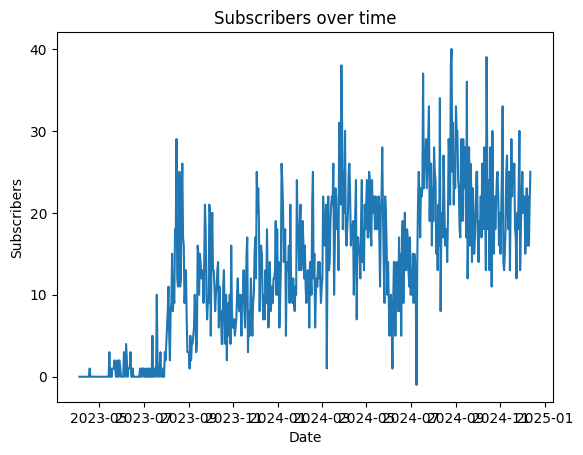

In [4]:
plot_data(clean_df["Subscribers"], title="Subscribers over time", x_label="Date", y_label="Subscribers")

In [5]:
x_train, x_test, y_train, y_test, scaler = prepare_train_test_data(data, time_step_in=7, time_step_out=7, test_size=0.2)

x_train shape: (484, 7), y_train shape: (484, 7), x_test shape: (121, 7), y_test shape: (121, 7)


In [6]:
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)
print(f"X_test shape => {x_test.shape}\nX_train shape => {x_train.shape}")

X_test shape => (121, 7, 1)
X_train shape => (484, 7, 1)


# model definition

In [9]:
lstm_model=Sequential()
lstm_model.add(LSTM(50,return_sequences=True,input_shape=(7,1)))
lstm_model.add(LSTM(50,return_sequences=True))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(7))
lstm_model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.03), metrics=['mean_absolute_error'])
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 7, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 7, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,157 (199.83 KB)

 Trainable params: 51,157 (199.83 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
tscv = TimeSeriesSplit(n_splits=5)
loss_total = []

for i, (train_index, test_index) in enumerate(tscv.split(x_train), 1):
    X_tr, X_val = x_train[train_index], x_train[test_index]
    y_tr, y_val = y_train[train_index], y_train[test_index]
    
    history = lstm_model.fit(
        X_tr, y_tr,  
        epochs=100, 
        validation_data=(X_val, y_val),  
        verbose=0  
    )
    
    y_pred = lstm_model.predict(X_val)
    loss = mean_absolute_error(y_val, y_pred)
    loss_total.append(loss)
    
  
    print(f"Fold {i}:")
    print(f"  Training data size: {X_tr.shape}")
    print(f"  Validation data size: {X_val.shape}")
    print(f"  MAE: {loss:.4f}")
    print("-" * 30)


mean_loss = np.mean(loss_total)
print(f'\nMean Loss (MAE) over all folds: {mean_loss:.4f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
Fold 1:
  Training data size: (84, 7, 1)
  Validation data size: (80, 7, 1)
  MAE: 0.1817
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold 2:
  Training data size: (164, 7, 1)
  Validation data size: (80, 7, 1)
  MAE: 0.1241
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 3:
  Training data size: (244, 7, 1)
  Validation data size: (80, 7, 1)
  MAE: 0.1356
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 4:
  Training data size: (324, 7, 1)
  Validation data size: (80, 7, 1)
  MAE: 0.2164
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 5:
  Training data size: (404, 7, 1)
  Validation data size: (80, 7, 1)
  MAE: 0.1495
------------------------------

Mean Loss (MAE) over all folds: 0.1615


In [12]:
all_predictions = []
input_window = x_test[-1]  

for i in range(1, 6): 
    print(f'Step {i} ==> Input Window: {input_window}')
    
    
    if len(input_window.shape) == 1:
        input_window = input_window.reshape(-1, 1)
    
    # Reshape input window to 3D for LSTM (1 sample, time_steps, features)
    y_temp = lstm_model.predict(input_window.reshape(1, input_window.shape[0], input_window.shape[1]))
    print(f"Prediction Output (y_temp): {y_temp}")
    all_predictions.extend(y_temp[0]) 
    input_window = np.roll(input_window, -1, axis=0)
    input_window[-1] = y_temp[0][0]  

Step 1 ==> Input Window: [[0.35897436]
 [0.48717949]
 [0.58974359]
 [0.66666667]
 [0.53846154]
 [0.58974359]
 [0.58974359]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction Output (y_temp): [[0.5728904  0.5134865  0.5298624  0.49862018 0.5152734  0.55017513
  0.689428  ]]
Step 2 ==> Input Window: [[0.48717949]
 [0.58974359]
 [0.66666667]
 [0.53846154]
 [0.58974359]
 [0.58974359]
 [0.5728904 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction Output (y_temp): [[0.49820173 0.47962856 0.47203824 0.52772254 0.6070474  0.63094497
  0.53548944]]
Step 3 ==> Input Window: [[0.58974359]
 [0.66666667]
 [0.53846154]
 [0.58974359]
 [0.58974359]
 [0.5728904 ]
 [0.49820173]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction Output (y_temp): [[0.5298784  0.46661705 0.53637946 0.5973393  0.5430745  0.43592483
  0.49404126]]
Step 4 ==> Input Window: [[0.66666667]
 [0.53846154]
 [0.58974359]
 [0.58974359]
 [0.5728904 ]
 [0.49820173]
 [0.52987838]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction Output (

In [13]:
all_predictions=np.array(all_predictions)
all_predictions

array([0.5728904 , 0.5134865 , 0.5298624 , 0.49862018, 0.5152734 ,
       0.55017513, 0.689428  , 0.49820173, 0.47962856, 0.47203824,
       0.52772254, 0.6070474 , 0.63094497, 0.53548944, 0.5298784 ,
       0.46661705, 0.53637946, 0.5973393 , 0.5430745 , 0.43592483,
       0.49404126, 0.44926953, 0.5021726 , 0.5784807 , 0.4523201 ,
       0.43912786, 0.5148997 , 0.5826617 , 0.50515157, 0.45954633,
       0.58742285, 0.52543485, 0.47012633, 0.5333506 , 0.54802835],
      dtype=float32)

In [14]:
num_samples = len(all_predictions) // 7
all_predictions_reshaped = all_predictions.reshape(num_samples, 7)
y_next_30 = scaler.inverse_transform(all_predictions_reshaped)
y_next_30=np.round(y_next_30)
print(y_next_30)

[[21. 19. 20. 18. 19. 20. 26.]
 [18. 18. 17. 20. 23. 24. 20.]
 [20. 17. 20. 22. 20. 16. 18.]
 [17. 19. 22. 17. 16. 19. 22.]
 [19. 17. 22. 19. 17. 20. 20.]]


In [15]:
x_train= x_train.reshape(x_train.shape[0], -1)
x_test= x_test.reshape(x_test.shape[0], -1)

print(f"X_test shape => {x_test.shape}\nX_train shape => {x_train.shape}")

X_test shape => (121, 7)
X_train shape => (484, 7)


In [16]:
x_test=scaler.inverse_transform(x_test)
x_train=scaler.inverse_transform(x_train)

In [17]:
x_test[-5:]

array([[20., 18., 23., 30., 13., 18., 22.],
       [18., 23., 30., 13., 18., 22., 25.],
       [23., 30., 13., 18., 22., 25., 20.],
       [30., 13., 18., 22., 25., 20., 22.],
       [13., 18., 22., 25., 20., 22., 22.]])

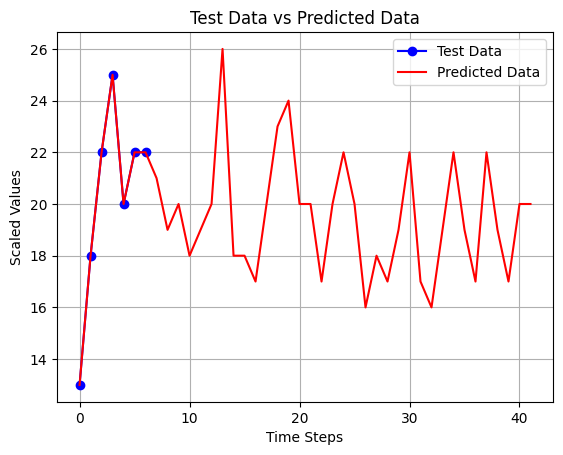

In [18]:
plt.plot(x_test[-1], label='Test Data', color='blue', marker='o')
plt.plot(np.hstack([x_test[-1], y_next_30.reshape(-1)]), label='Predicted Data', color='red')
plt.title('Test Data vs Predicted Data')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
last_date = clean_df.index[-1]
total_sub=np.sum(clean_df["Subscribers"])
total_next_30=np.sum(y_next_30)
print(f"Total subscribers till {last_date}: {total_sub}, next_30_days: {total_next_30} => final after 30 days: {total_sub + total_next_30}")

Total subscribers till 2024-12-12 00:00:00: 8117, next_30_days: 682.0 => final after 30 days: 8799.0


In [20]:
avg_sub = np.mean(np.array(clean_df['Subscribers']))
avg_sub * 30

393.3925686591276